In [1]:
from selenium import webdriver
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta

# dangerous but dirty hack to let me get csv from nytimes github
import ssl
ssl._create_default_https_context = ssl._create_unverified_context 

## Specify party of state governors

From https://en.wikipedia.org/wiki/List_of_United_States_governors

In [100]:
parties = {
    'Alabama': 'R',
    'Alaska': 'R',
    'Arizona': 'R',
    'Arkansas': 'R',
    'California': 'D',
    'Colorado': 'D',
    'Connecticut': 'D',
    'Delaware': 'D',
    'Florida': 'R',
    'Georgia': 'R',
    'Hawaii': 'D',
    'Idaho': 'R',
    'Illinois': 'D',
    'Indiana': 'R',
    'Iowa': 'R',
    'Kansas': 'D',
    'Kentucky': 'D',
    'Louisiana': 'D',
    'Maine': 'D',
    'Maryland': 'R',
    'Massachusetts': 'R',
    'Michigan': 'D',
    'Minnesota': 'D',
    'Mississippi': 'R',
    'Missouri': 'R',
    'Montana': 'D',
    'Nebraska': 'R',
    'Nevada': 'D',
    'New Hampshire': 'R',
    'New Jersey': 'D',
    'New Mexico': 'D',
    'New York': 'D',
    'North Carolina': 'D',
    'North Dakota': 'R',
    'Ohio': 'R',
    'Oklahoma': 'R',
    'Oregon': 'D',
    'Pennsylvania': 'D',
    'Rhode Island': 'D',
    'South Carolina': 'R',
    'South Dakota': 'R',
    'Tennessee': 'R',
    'Texas': 'R',
    'Utah': 'R',
    'Vermont': 'R',
    'Virginia': 'D',
    'Washington': 'D',
    'West Virginia': 'R',
    'Wisconsin': 'D',
    'Wyoming': 'R',
    'District of Columbia': 'D',
    'Puerto Rico': 'D'
}

len(parties)

52

## Load cases data

Will need to load counties or something to account for places in the stay at home orders.

In [7]:
state_cases = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv')

In [8]:
state_cases

,date,state,fips,cases,deaths
0,2020-01-21,Washington,53,1,0
1,2020-01-22,Washington,53,1,0
2,2020-01-23,Washington,53,1,0
3,2020-01-24,Illinois,17,1,0
4,2020-01-24,Washington,53,1,0
...,...,...,...,...,...
1604,2020-03-31,Virginia,51,1250,27
1605,2020-03-31,Washington,53,5292,226
1606,2020-03-31,West Virginia,54,162,1
1607,2020-03-31,Wisconsin,55,1351,25


## Scrape stay at home orders

In [2]:
browser = webdriver.Firefox(executable_path='/usr/local/bin/geckodriver')
url = 'https://www.nytimes.com/interactive/2020/us/coronavirus-stay-at-home-order.html?smid=ig-nytimes&utm_source=like2buy.curalate.com&crl8_id=3b7a7632-c666-4d1b-955d-e8cadc22aaae'
browser.get(url)

order_nodes = browser.find_elements_by_xpath("//div[starts-with(@id, 'item-')]")
print('States that have issued orders: ' + str(len(order_nodes)))

States that have issued orders: 47


In [3]:
def get_place_name(node, type_of_node=None):
    
    if type_of_node == 'state':
        node = node.find_element_by_tag_name('h3')
    name = node.text
    children = node.find_elements_by_xpath('./*')
    for child in children: 
        name = name.replace(child.text, '').strip()
    return name
    
def format_order(order):
    return order.text.split(',')[0].lower()

def format_date(date):
    text = re.search('[A-Z]\w* \d*', date.text)[0]
    month = text.split(' ')[0][:3]
    day = text.split(' ')[1]
    return month + ' ' + day

def format_population(pop):
    num = re.search('(\d*[\,.]?\d+)( [m]\w+)?', pop.text)[0]
    parts = num.split(' ')
    if len(parts) > 1:
        num = int(float(parts[0]) * 1000000)
    else:
        num = int(num.replace(',', ''))
    return num

In [4]:
data = {'state': [], 'place': [], 'population': [], 'order': [], 'date': []}

for order_node in order_nodes:
    state_name = get_place_name(order_node, 'state')
    places = order_node.find_elements_by_class_name('l-place')
    populations = order_node.find_elements_by_class_name('l-population')
    orders = order_node.find_elements_by_class_name('l-order')
    dates = order_node.find_elements_by_class_name('l-date')                        
    
    if not places:
        data['state'].append(state_name)
        data['place'].append(None)
        data['population'].append(format_population(populations[0]))
        data['order'].append(format_order(orders[0]))
        data['date'].append(format_date(dates[0]))
    else:
        for i, place in enumerate(places):
            data['state'].append(state_name)
            data['place'].append(get_place_name(place))
            data['population'].append(format_population(populations[i]))
            data['order'].append(format_order(orders[i]))
            data['date'].append(format_date(dates[i]))

In [5]:
orders = pd.DataFrame(data)
orders

,state,place,population,order,date
0,Alabama,Birmingham,210000,shelter in place,Mar 24
1,Alaska,None,737000,stay at home,Mar 28
2,Arizona,None,7200000,stay at home,Mar 31
3,California,None,39600000,stay at home,Mar 19
4,Colorado,None,5700000,stay at home,Mar 26
...,...,...,...,...,...
122,Virginia,None,8500000,stay at home,Mar 30
123,Washington,None,7500000,stay at home,Mar 23
124,West Virginia,None,1800000,stay at home,Mar 24
125,Wisconsin,None,5800000,stay at home,Mar 25


Collect only the state-level orders:

In [84]:
state_orders = orders[orders['place'].isna()].reset_index(drop=True)
state_orders

,state,place,population,order,date
0,Alaska,None,737000,stay at home,Mar 28
1,Arizona,None,7200000,stay at home,Mar 31
2,California,None,39600000,stay at home,Mar 19
3,Colorado,None,5700000,stay at home,Mar 26
4,Connecticut,None,3600000,stay at home,Mar 23
5,Delaware,None,973000,shelter in place,Mar 24
6,District of Columbia,None,702000,stay at home,Apr 1
7,Florida,None,21500000,stay at home,Apr 3
8,Georgia,None,10600000,shelter in place,Apr 3
9,Hawaii,None,1400000,stay at home,Mar 25


Add states that have not issued any orders:

In [85]:
state_names = list(state_cases['state'].value_counts().keys())
state_names.remove('Puerto Rico')
state_names.remove('Guam')
state_names.remove('Northern Mariana Islands')
state_names.remove('Virgin Islands')

for name in state_names:
    if name not in state_orders['state'].values:
        print(name)
        state_orders = state_orders.append({'state': name, 'place': None, 'population': None, 'order': None, 'date': None}, ignore_index=True)

Texas
Nebraska
Utah
South Carolina
Oklahoma
Pennsylvania
Missouri
Iowa
South Dakota
Arkansas
Wyoming
North Dakota
Alabama


,state,place,population,order,date
0,Alabama,None,None,None,None
1,Alaska,None,737000,stay at home,Mar 28
2,Arizona,None,7200000,stay at home,Mar 31
3,Arkansas,None,None,None,None
4,California,None,39600000,stay at home,Mar 19
5,Colorado,None,5700000,stay at home,Mar 26
6,Connecticut,None,3600000,stay at home,Mar 23
7,Delaware,None,973000,shelter in place,Mar 24
8,District of Columbia,None,702000,stay at home,Apr 1
9,Florida,None,21500000,stay at home,Apr 3


Sort by date order was placed:

In [116]:
state_orders['datetime'] = pd.to_datetime('2020 ' + state_orders['date'],  format = '%Y %b %d')
state_orders = state_orders.sort_values(by=['datetime', 'state']).reset_index(drop=True)
state_orders

,state,place,population,order,date,datetime
0,Puerto Rico,None,3200000,curfew,Mar 15,2020-03-15
1,California,None,39600000,stay at home,Mar 19,2020-03-19
2,Illinois,None,12700000,stay at home,Mar 21,2020-03-21
3,New Jersey,None,8900000,stay at home,Mar 21,2020-03-21
4,New York,None,19500000,stay at home,Mar 22,2020-03-22
5,Connecticut,None,3600000,stay at home,Mar 23,2020-03-23
6,Louisiana,None,4600000,stay at home,Mar 23,2020-03-23
7,Ohio,None,11700000,stay at home,Mar 23,2020-03-23
8,Oregon,None,4200000,stay at home,Mar 23,2020-03-23
9,Washington,None,7500000,stay at home,Mar 23,2020-03-23


## Plot daily cases

Set range of dates. First case in America was on January 21, 2020. 

In [9]:
base = datetime(2020, 1, 21)
yesterday = datetime.today() - timedelta(days = 1)
total_days = abs((base - yesterday).days)
print('Days since first case in the US: ' + str(total_days))

Days since first case in the US: 71


In [10]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug']
master_date_list = pd.date_range(base, periods=total_days).tolist()
master_date_list = [months[x.month - 1] + ' ' + str(x.day) for x in master_date_list]
print(master_date_list)

['Jan 21', 'Jan 22', 'Jan 23', 'Jan 24', 'Jan 25', 'Jan 26', 'Jan 27', 'Jan 28', 'Jan 29', 'Jan 30', 'Jan 31', 'Feb 1', 'Feb 2', 'Feb 3', 'Feb 4', 'Feb 5', 'Feb 6', 'Feb 7', 'Feb 8', 'Feb 9', 'Feb 10', 'Feb 11', 'Feb 12', 'Feb 13', 'Feb 14', 'Feb 15', 'Feb 16', 'Feb 17', 'Feb 18', 'Feb 19', 'Feb 20', 'Feb 21', 'Feb 22', 'Feb 23', 'Feb 24', 'Feb 25', 'Feb 26', 'Feb 27', 'Feb 28', 'Feb 29', 'Mar 1', 'Mar 2', 'Mar 3', 'Mar 4', 'Mar 5', 'Mar 6', 'Mar 7', 'Mar 8', 'Mar 9', 'Mar 10', 'Mar 11', 'Mar 12', 'Mar 13', 'Mar 14', 'Mar 15', 'Mar 16', 'Mar 17', 'Mar 18', 'Mar 19', 'Mar 20', 'Mar 21', 'Mar 22', 'Mar 23', 'Mar 24', 'Mar 25', 'Mar 26', 'Mar 27', 'Mar 28', 'Mar 29', 'Mar 30', 'Mar 31']


In [11]:
def format_x(df, start):
    x = [] 
    for i in list(df['date'].str.split('-')):
        date = months[int(i[1]) - 1] + ' ' + str(int(i[2]))
        x.append(date)
    num_of_days = len(x)
    missing_days = total_days - num_of_days
    missing_counts = [master_date_list[i] for i in range(missing_days)]
    x = missing_counts + x
    return x

def format_y(x, y):
    # Make the length of y equal to x, if not already,
    # by appending zero counts to the beginning of y
    if len(x) > len(y):
        missing_counts = [0 for i in range(len(x) - len(y))]
        y = missing_counts + y
    return y

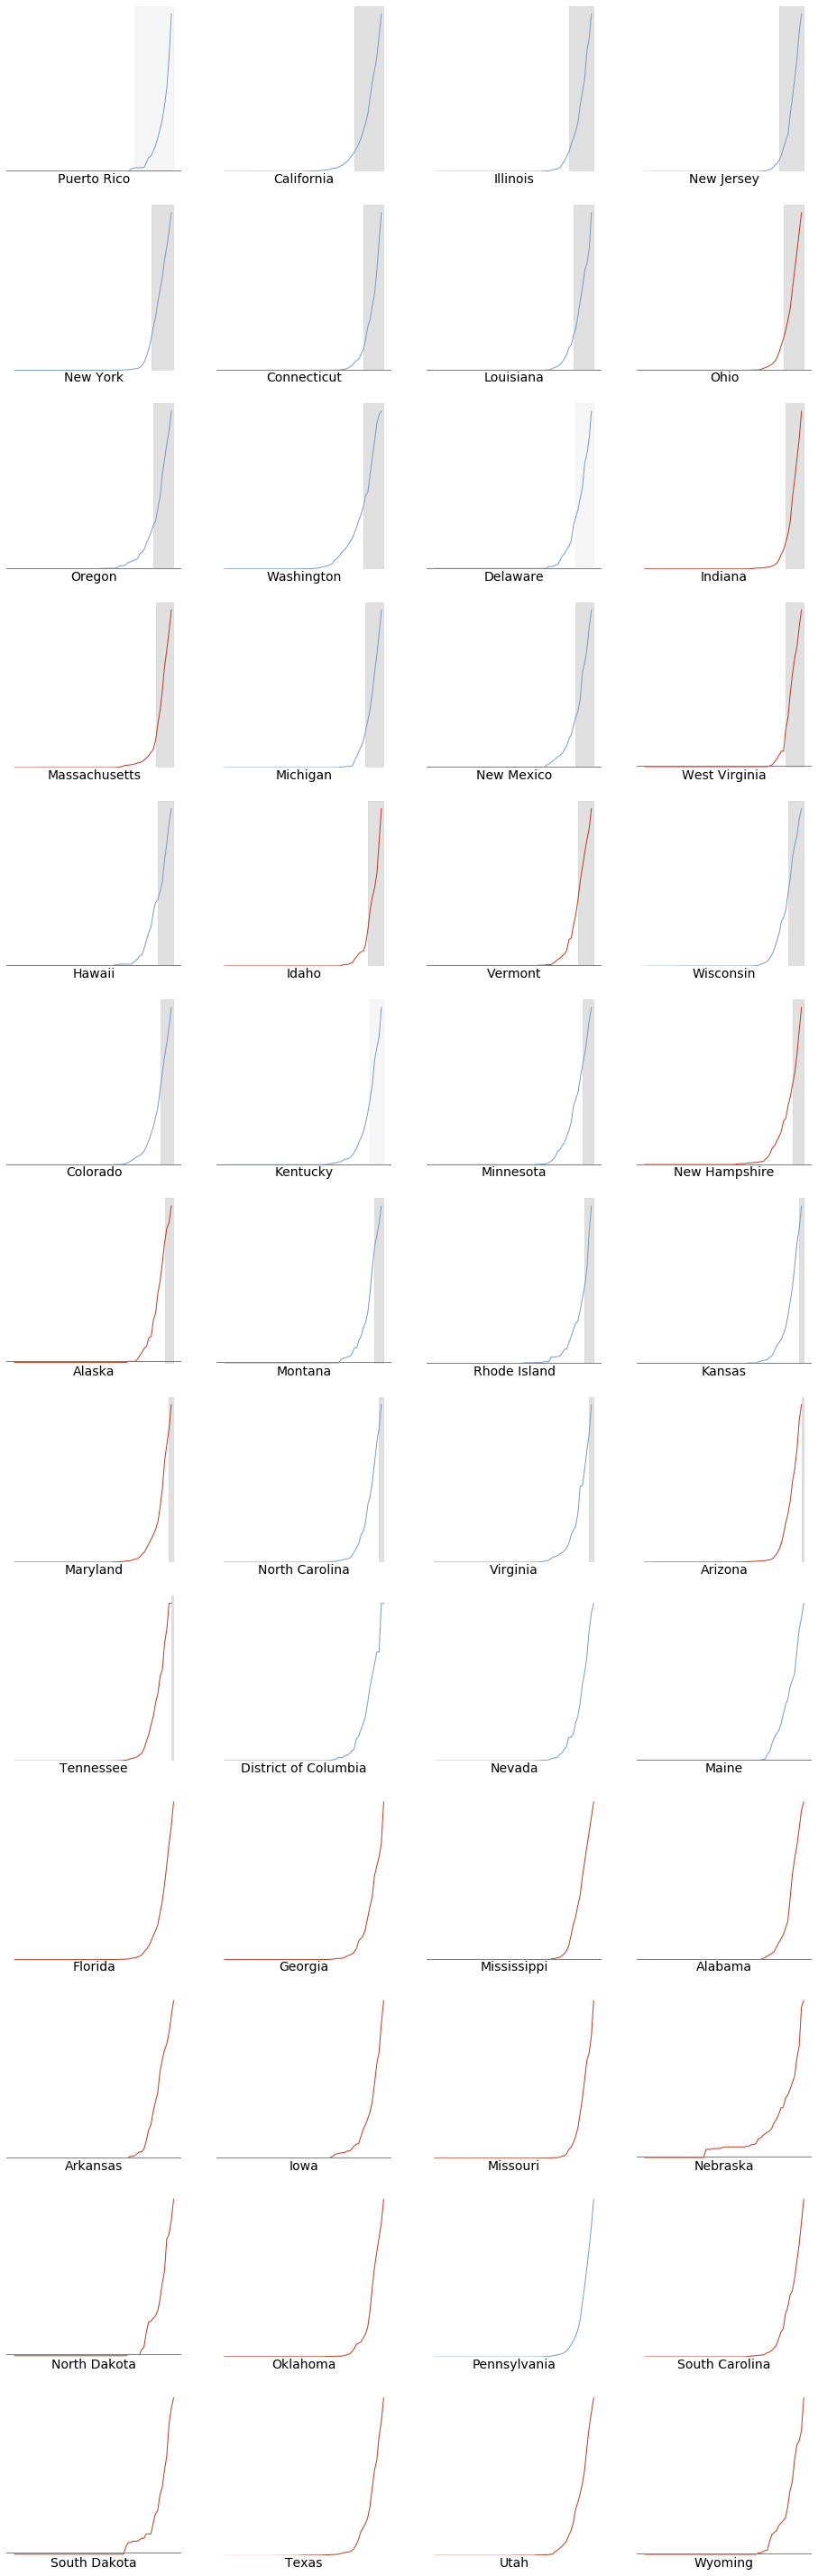

In [117]:
fig, axarr = plt.subplots(13, 4, figsize=(16,52))
tracker = 0

# For each state that has issued a state-wide order
for row in range(0, 13):    
    for col in range(0, 4):
        state_order = state_orders.iloc[tracker]
        tracker += 1
    
        # Get order details
        state = state_order['state']
        order = state_order['order']
        order_date = state_order['date']
        #print('\n' + state)

        # Get covid-19 data
        data = state_cases[state_cases['state'] == state]
        x = format_x(data, 1)
        #print(x)
        y = format_y(x, list(data['cases']))
        #print(y)
    
        if parties[state] == 'D':
            color = '#779ecb'
        else: 
            color = '#c23b22'
            
        plt.sca(axarr[row, col])
        axarr[row, col].plot(x, y, color=color, lw=1)
        axarr[row, col].axis('off')
        axarr[row, col].set_title(state, y=-0.1, fontsize=14)
        axarr[row, col].set_ylim(-1, None)
        axarr[row, col].axhline(y=1, color='gray', lw=1)

        # If order is not made after yesterday, 
        if order_date and order_date != 'Apr 1' and order_date != 'Apr 2' and order_date != 'Apr 3':
            if 'stay at home' in order:
                a = 0.7
            else:
                a = 0.2
            axarr[row, col].axvspan(xmin=x.index(order_date), xmax=len(x), alpha=a, color='#D3D3D3') 

    
#plt.tight_layout()   
plt.savefig('social_distancing.png', bbox_inches='tight')   

## Plot weekly cases